In [32]:
import numpy as np
import math
import pandas as pd

from numba import jit

import timeit
from timeit import default_timer as timer

In [33]:
%matplotlib inline

In [34]:
def assetPathsCPU(S0,mu,sigma,T,nRows,nPaths):
    dt = T/nRows
    nudt = (mu-0.5*sigma**2)*dt    
    sidt = sigma*math.sqrt(dt)
    increments = nudt + sidt*np.random.randn(int(nRows),int(nPaths))
    x=np.concatenate((math.log(S0)*np.ones((1,int(nPaths))),increments))
    pricePaths=np.exp(np.cumsum(x,axis=0))

    return pricePaths


In [35]:
%%timeit

nRows=252*10
nPaths=10000
# define parameters
S0 = 100.0
T = 10.0
mu = 0.1
sigma = 0.1
# simulate price paths
assetPathsCPU(S0,mu,sigma,T,nRows,nPaths)


1.37 s ± 25.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
# define simulation parameters
nRows=252*10
nPaths=1000
# define parameters
S0 = 100.0
T = 10.0
mu = 0.1
sigma = 0.1
# simulate price paths
pricePathsCPU=assetPathsCPU(S0,mu,sigma,T,nRows,nPaths)


In [37]:
df=pd.DataFrame(pricePathsCPU)

Classical momentum computes growth 

In [38]:
x=np.arange(0,10)


In [39]:
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [40]:
x[0]


0

In [41]:
x[-1]


9

In [42]:
def linregressCPU(x, y):

    TINY = 1.0e-20

    x = np.asarray(x)
    y = np.asarray(y)

    n = len(x)
    xmean = np.mean(x)
    ymean = np.mean(y)

    # average sum of squares:
    ssxm, ssxym, ssyxm, ssym = np.cov(x, y, bias=1).flat
    r_num = ssxym
    r_den = np.sqrt(ssxm * ssym)
    if r_den == 0.0:
        r = 0.0
    else:
        r = r_num / r_den
        # test for numerical error propagation
        if r > 1.0:
            r = 1.0
        elif r < -1.0:
            r = -1.0

    df = n - 2
    slope = r_num / ssxm
    intercept = ymean - slope*xmean
    if n == 2:
        sterrest = 0.0
    else:
        t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
        sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)

    return (slope, intercept, r, sterrest)


In [43]:
# compute classical price momentum
def price2ClassicalMomentum(y):    
    return ((1+((np.log(y[-1])-np.log(y[0]))/len(y)))**252.0)-1

In [44]:
@jit(nopython=True)
# compute classical price momentum
def price2ClassicalMomentumNumba(y):    
    return ((1+((np.log(y[-1])-np.log(y[0]))/len(y)))**252.0)-1


In [45]:
# compute price momentum
def price2momentum(y):
    x=np.arange(0,len(y))
    slope, intercept, r_value, sterrest = linregressCPU(x,
        np.log(y))
    # adjust the momentum for smoothness and annualize
    momentum=(((1+slope)**252.0)-1)*(r_value**2.0)
    return momentum


In [46]:
@jit(nopython=True)
# compute price momentum
def price2momentumNumba(y):
    x=np.arange(0,len(y))
    slope, intercept, r_value, sterrest = linregressCPU(x,
        np.log(y))
    # adjust the momentum for smoothness and annualize
    momentum=(((1+slope)**252.0)-1)*(r_value**2.0)
    return momentum


In [47]:
hpr=1.1**(1.0/252.0)
#y=np.ones(252)*growth
hpr

1.0003782865315343

In [48]:
hpr**252.0

1.1000000000000063

In [49]:
np.log(hpr)

0.0003782149992235343

In [50]:
y=np.exp(np.cumsum(np.ones(2520)*np.log(hpr)))

In [51]:
yy=y[0:90]

In [52]:
len(yy)

90

In [53]:
((1+((np.log(yy[-1])-np.log(yy[0]))/len(yy)))**252.0)-1

0.09881635180021897

In [54]:
x=np.arange(0,len(yy))
slope, intercept, r_value, sterrest = linregressCPU(x,np.log(yy))
# adjust the momentum for smoothness and annualize
momentum=(((1+slope)**252.0)-1)*(r_value**2.0)

In [55]:
r_value

1.0

In [56]:
momentum

0.09998017891945699

In [57]:
trendDf=pd.DataFrame(y)

In [58]:
trendDf.tail()

,0
2515,2.589821
2516,2.590801
2517,2.591781
2518,2.592762
2519,2.593742


In [59]:
%%timeit
momentumLookback=90
# compute momentum
df.rolling(center=False,window=momentumLookback).apply(func=price2ClassicalMomentum,
    raw=True)


9.1 s ± 336 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [60]:
%%timeit
momentumLookback=90
# compute momentum
df.rolling(center=False,window=momentumLookback).apply(func=price2ClassicalMomentumNumba,
    raw=True)


843 ms ± 20.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
%%timeit
momentumLookback=90
# compute momentum
df.rolling(center=False,window=momentumLookback).apply(func=price2momentum,
    raw=True)

2min 36s ± 7.77 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
#%%timeit
#momentumLookback=90
## compute momentum
#df.rolling(center=False,window=momentumLookback).apply(func=price2momentumNumba,
#    raw=True)

In [63]:
momentumLookback=90
# compute momentum
momentumDf=df.rolling(center=False,window=momentumLookback).apply(func=price2ClassicalMomentum,
    raw=True)

In [64]:
%%timeit
momentumLookback=90
# compute momentum
trendDf.rolling(center=False,window=momentumLookback).apply(func=price2ClassicalMomentum,
    raw=True)

10.2 ms ± 267 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [65]:
#
momentumLookback=90
#
trendMomentum=trendDf.rolling(center=False,window=momentumLookback).apply(func=price2ClassicalMomentum,
    raw=True)

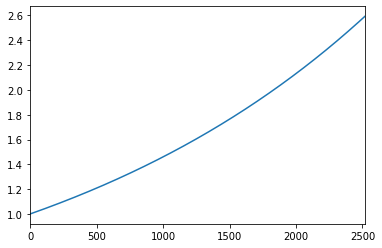

In [66]:
trendDf.plot(legend=False)

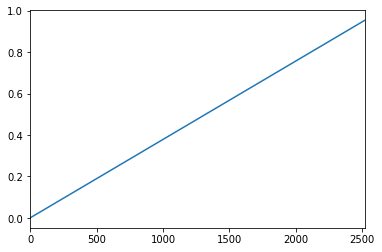

In [67]:
trendDf.apply(lambda x: np.log(x)).plot(legend=False)

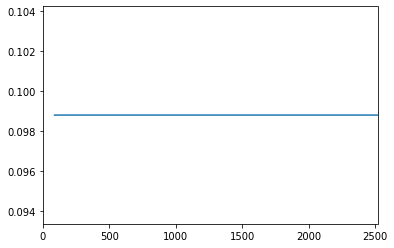

In [68]:
trendMomentum.plot(legend=False)

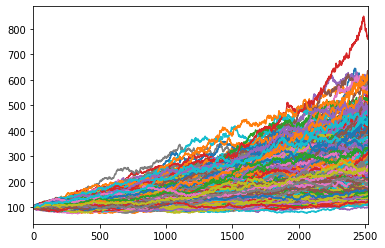

In [69]:
df.plot(legend=False)

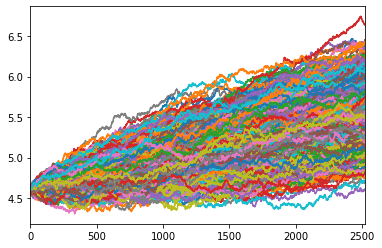

In [70]:
df.apply(lambda x : np.log(x)).plot(legend=False)

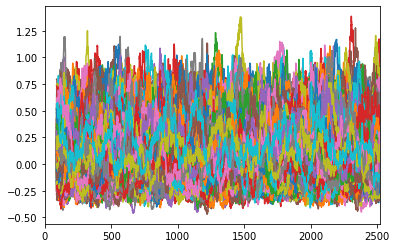

In [71]:
momentumDf.plot(legend=False)

In [72]:
momentumPercentileDf=momentumDf.quantile([.1, .5,.9],axis=1).T

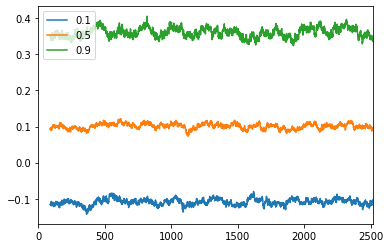

In [73]:
momentumPercentileDf.plot()

In [74]:
momentumPercentileDf.mean()

0.1   -0.108981
0.5    0.100902
0.9    0.360368
dtype: float64

In [75]:
percentileDf=df.quantile([.1, .5,.9],axis=1).T

In [76]:
((percentileDf[0.5].values[90]/percentileDf[0.5].values[0])**(252/momentumLookback))-1

0.09492752045341302

In [77]:
((1+((np.log(percentileDf[0.5].values[90])-np.log(percentileDf[0.5].values[0]))/momentumLookback))**252.0)-1

0.09490965770063431

In [78]:
medianMomentum=percentileDf[0.5].rolling(center=False,window=momentumLookback).apply(func=price2ClassicalMomentum,
    raw=True)

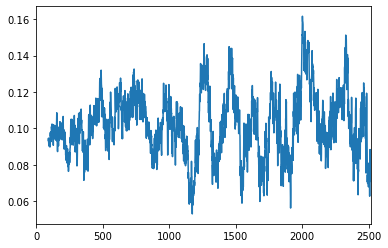

In [79]:
medianMomentum.plot(legend=False)

In [80]:
import dask.dataframe as dd

In [81]:
#%%timeit
#nPartitions=252*10
#momentumLookback=90
#dA = dd.from_pandas(df, npartitions=nPartitions)
#dA.rolling(window=momentumLookback, center=False).apply(func=price2ClassicalMomentum2,
#    raw=True).compute()


In [82]:
nPartitions=90
momentumLookback=90
dA = dd.from_pandas(df, npartitions=nPartitions)
priceMomentum=dA.rolling(window=momentumLookback, center=False).apply(func=price2ClassicalMomentum2,
    raw=True)

NameError: name 'price2ClassicalMomentum2' is not defined

In [ ]:
priceMomentum.to_pandas.plot()